In [1]:
#hide
#!pip install -Uqq fastai
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Data Munging with fastai's Mid-Level API

We have seen what `Tokenizer` and `Numericalize` do to a collection of texts, and how they're used inside the data block API, which handles those transforms for us directly using the `TextBlock`. But what if we want to only apply one of those transforms, either to see intermediate results or because we have already tokenized texts? More generally, what can we do when the data block API is not flexible enough to accommodate our particular use case? For this, we need to use fastai's *mid-level API* for processing data. The data block API is built on top of that layer, so it will allow you to do everything the data block API does, and much much more.

우리는`Tokenizer`와`Numericalize`가 텍스트 컬렉션에 어떤 일을하는지, 그리고`TextBlock`을 사용하여 이러한 변환을 직접 처리하는 데이터 블록 API 내에서 어떻게 사용되는지 살펴 보았습니다. 그러나 중간 결과를 보거나 이미 텍스트를 토큰 화했기 때문에 이러한 변환 중 하나만 적용하려면 어떻게해야합니까? 보다 일반적으로 데이터 블록 API가 특정 사용 사례를 수용 할 수있을만큼 유연하지 않은 경우 어떻게 할 수 있습니까? 이를 위해 데이터 처리를 위해 fastai의 * 중간 수준 API *를 사용해야합니다. 데이터 블록 API는 해당 레이어 위에 구축되므로 데이터 블록 API가 수행하는 모든 작업과 그 밖의 많은 작업을 수행 할 수 있습니다.

## Going Deeper into fastai's Layered API

The fastai library is built on a *layered API*. In the very top layer there are *applications* that allow us to train a model in five lines of codes, as we saw in <<chapter_intro>>. In the case of creating `DataLoaders` for a text classifier, for instance, we used the line:

fastai 라이브러리는 * 계층화 된 API *를 기반으로합니다. 맨 위 계층에는 << chapter_intro >>에서 본 것처럼 5 줄의 코드로 모델을 훈련시킬 수있는 * 애플리케이션 *이 있습니다. 예를 들어 텍스트 분류 자에 대한`DataLoaders`를 생성하는 경우 다음 행을 사용했습니다.

In [3]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

The factory method `TextDataLoaders.from_folder` is very convenient when your data is arranged the exact same way as the IMDb dataset, but in practice, that often won't be the case. The data block API offers more flexibility. As we saw in the last chapter, we can get the same result with:

팩토리 메소드`TextDataLoaders.from_folder`는 데이터가 IMDb 데이터 세트와 똑같은 방식으로 배열 될 때 매우 편리하지만 실제로는 그렇지 않습니다. 데이터 블록 API는 더 많은 유연성을 제공합니다. 지난 장에서 보았 듯이 다음과 같은 결과를 얻을 수 있습니다.

In [4]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

But it's sometimes not flexible enough. For debugging purposes, for instance, we might need to apply just parts of the transforms that come with this data block. Or we might want to create a `DataLoaders` for some application that isn't directly supported by fastai. In this section, we'll dig into the pieces that are used inside fastai to implement the data block API. Understanding these will enable you to leverage the power and flexibility of this mid-tier API.

그러나 때로는 충분히 유연하지 않습니다. 예를 들어 디버깅 목적으로이 데이터 블록과 함께 제공되는 변환의 일부만 적용해야 할 수 있습니다. 또는 fastai에서 직접 지원하지 않는 일부 애플리케이션에 대해 'DataLoaders'를 생성 할 수 있습니다. 이 섹션에서는 fastai 내부에서 데이터 블록 API를 구현하는 데 사용되는 부분을 살펴 보겠습니다. 이를 이해하면이 미드 티어 API의 성능과 유연성을 활용할 수 있습니다.

> note: Mid-Level API: The mid-level API does not only contain functionality for creating `DataLoaders`. It also has the _callback_ system, which allows us to customize the training loop any way we like, and the _general optimizer_. Both will be covered in <<chapter_accel_sgd>>.

> 참고 : 중간 수준 API : 중간 수준 API에는 'DataLoaders'생성 기능 만 포함되어 있지 않습니다. 또한 우리가 원하는 방식으로 훈련 루프를 사용자 정의 할 수있는 _callback_ 시스템과 _general optimizer_가 있습니다. 둘 다 << chapter_accel_sgd >>에서 다룹니다.

### Transforms(변형)

When we studied tokenization and numericalization in the last chapter, we started by grabbing a bunch of texts:

지난 장에서 토큰 화와 수치화를 연구했을 때, 우리는 여러 텍스트를 수집하는 것으로 시작했습니다.

In [5]:
files = get_text_files(path, folders = ['train', 'test'])
txts = L(o.open().read() for o in files[:2000])

We then showed how to tokenize them with a `Tokenizer`:
그런 다음 '토케 나이저'로 토큰 화하는 방법을 보여주었습니다.

In [6]:
tok = Tokenizer.from_folder(path)
tok.setup(txts)
toks = txts.map(tok)
toks[0]

(#443) ['xxbos','xxmaj','funny','thing','.','xxmaj','charlie','xxmaj','sheen',','...]

and how to numericalize, including automatically creating the vocab for our corpus:

코퍼스에 대한 어휘를 자동으로 생성하는 것을 포함하여 수치화하는 방법 :

In [7]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([   2,    8,  175,  145,   10,    8, 1180,    8, 2672,   11])

The classes also have a `decode` method. For instance, `Numericalize.decode` gives us back the string tokens:

클래스에는 'decode'메소드도 있습니다. 예를 들어`Numericalize.decode`는 문자열 토큰을 반환합니다.

In [8]:
nums_dec = num.decode(nums[0][:10]); nums_dec

(#10) ['xxbos','xxmaj','funny','thing','.','xxmaj','charlie','xxmaj','sheen',',']

and `Tokenizer.decode` turns this back into a single string (it may not, however, be exactly the same as the original string; this depends on whether the tokenizer is *reversible*, which the default word tokenizer is not at the time we're writing this book):

그리고`Tokenizer.decode`는 이것을 단일 문자열로 다시 변환합니다 (그러나 원래 문자열과 정확히 같지 않을 수 있습니다. 이것은 토크 나이저가 * reversible *인지 여부에 따라 달라지며, 기본 단어 토크 나이 저는 당시가 아닙니다. 우리는이 책을 쓰고 있습니다) :

In [9]:
tok.decode(nums_dec)

'xxbos xxmaj funny thing . xxmaj charlie xxmaj sheen ,'

`decode` is used by fastai's `show_batch` and `show_results`, as well as some other inference methods, to convert predictions and mini-batches into a human-understandable representation.

`decode`는 fastai의`show_batch` 및`show_results`뿐만 아니라 다른 추론 방법에서 예측 및 미니 배치를 사람이 이해할 수있는 표현으로 변환하는 데 사용됩니다.

For each of `tok` or `num` in the preceding example, we created an object, called the `setup` method (which trains the tokenizer if needed for `tok` and creates the vocab for `num`), applied it to our raw texts (by calling the object as a function), and then finally decoded the result back to an understandable representation. These steps are needed for most data preprocessing tasks, so fastai provides a class that encapsulates them. This is the `Transform` class. Both `Tokenize` and `Numericalize` are `Transform`s.

앞의 예에서`tok` 또는`num` 각각에 대해`setup` 메소드 (`tok`에 필요한 경우 토크 나이저를 훈련시키고`num`에 대한 어휘를 생성 함)라는 객체를 생성하여 적용했습니다. 원시 텍스트 (객체를 함수로 호출) 한 다음 결과를 다시 이해할 수있는 표현으로 디코딩했습니다. 이러한 단계는 대부분의 데이터 전처리 작업에 필요하므로 fastai는이를 캡슐화하는 클래스를 제공합니다. 이것이`Transform` 클래스입니다. `Tokenize`와`Numericalize`는 모두`Transform`입니다.

In general, a `Transform` is an object that behaves like a function and has an optional `setup` method that will initialize some inner state (like the vocab inside `num`) and an optional `decode` that will reverse the function (this reversal may not be perfect, as we saw with `tok`).
일반적으로`Transform`은 함수처럼 동작하는 객체이며 내부 상태 (`num` 내부의 vocab과 같은)를 초기화하는 선택적`setup` 메소드와 함수를 반전시키는 선택적`decode` ( 이 반전은 우리가 'tok'에서 본 것처럼 완벽하지 않을 수 있습니다.

A good example of `decode` is found in the `Normalize` transform that we saw in <<chapter_sizing_and_tta>>: to be able to plot the images its `decode` method undoes the normalization (i.e., it multiplies by the standard deviation and adds back the mean). On the other hand, data augmentation transforms do not have a `decode` method, since we want to show the effects on images to make sure the data augmentation is working as we want.

`decode`의 좋은 예는 << chapter_sizing_and_tta >>에서 본`Normalize` 변환에서 찾을 수 있습니다. 이미지를 플로팅 할 수있는`decode` 메서드는 정규화를 취소합니다 (즉, 표준 편차를 곱하고 평균을 다시 추가합니다). 반면에 데이터 증가 변환에는 '디코딩'방법이 없습니다. 데이터 증가가 원하는대로 작동하는지 확인하기 위해 이미지에 대한 효과를 표시하려고하기 때문입니다.

A special behavior of `Transform`s is that they always get applied over tuples. In general, our data is always a tuple `(input,target)` (sometimes with more than one input or more than one target). When applying a transform on an item like this, such as `Resize`, we don't want to resize the tuple as a whole; instead, we want to resize the input (if applicable) and the target (if applicable) separately. It's the same for batch transforms that do data augmentation: when the input is an image and the target is a segmentation mask, the transform needs to be applied (the same way) to the input and the target.

`Transform`의 특별한 동작은 항상 튜플에 적용된다는 것입니다. 일반적으로 데이터는 항상 튜플`(input, target)`(때로는 하나 이상의 입력 또는 둘 이상의 대상이 있음)입니다. `Resize`와 같은 항목에 변형을 적용 할 때 튜플 전체의 크기를 조정하고 싶지 않습니다. 대신 입력 (해당되는 경우)과 대상 (해당하는 경우)의 크기를 개별적으로 조정하려고합니다. 데이터 증가를 수행하는 일괄 변환의 경우도 동일합니다. 입력이 이미지이고 대상이 세분화 마스크 인 경우 변환을 입력과 대상에 (동일한 방식으로) 적용해야합니다.

We can see this behavior if we pass a tuple of texts to `tok`:
텍스트 튜플을`tok`에 전달하면이 동작을 볼 수 있습니다.

In [10]:
tok((txts[0], txts[1]))

((#443) ['xxbos','xxmaj','funny','thing','.','xxmaj','charlie','xxmaj','sheen',','...],
 (#78) ['xxbos','xxmaj','sickening','exploitation','trash','plays','like','a','bad','('...])

### Writing Your Own Transform

If you want to write a custom transform to apply to your data, the easiest way is to write a function. As you can see in this example, a `Transform` will only be applied to a matching type, if a type is provided (otherwise it will always be applied). In the following code, the `:int` in the function signature means that `f` only gets applied to `int`s. That's why `tfm(2.0)` returns `2.0`, but `tfm(2)` returns `3` here:

데이터에 적용 할 사용자 지정 변환을 작성하려는 경우 가장 쉬운 방법은 함수를 작성하는 것입니다. 이 예에서 볼 수 있듯이 'Transform'은 유형이 제공되는 경우 일치하는 유형에만 적용됩니다 (그렇지 않으면 항상 적용됨). 다음 코드에서 함수 시그니처의`: int`는`f`가 ʻint`에만 적용됨을 의미합니다. 그래서`tfm (2.0)`은`2.0`을 반환하지만`tfm (2)`는 여기서`3`을 반환합니다.

In [11]:
def f(x:int): return x+1
tfm = Transform(f)
tfm(2),tfm(2.0)

(3, 2.0)

Here, `f` is converted to a `Transform` with no `setup` and no `decode` method.
여기서 'f'는 '설정'과 '디코딩'메서드가없는 'Transform'으로 변환됩니다.

Python has a special syntax for passing a function (like `f`) to another function (or something that behaves like a function, known as a *callable* in Python), called a *decorator*. A decorator is used by prepending a callable with `@` and placing it before a function definition (there are lots of good online tutorials about Python decorators, so take a look at one if this is a new concept for you). The following is identical to the previous code:

Python에는 * decorator *라고하는 다른 함수 (또는 Python에서 * callable *로 알려진 함수처럼 동작하는 함수)에 함수 (`f`와 같은)를 전달하는 특수 구문이 있습니다. 데코레이터는 콜 러블 앞에`@ '를 붙여서 함수 정의 앞에 놓는 방식으로 사용됩니다 (파이썬 데코레이터에 대한 좋은 온라인 자습서가 많이 있으므로 이것이 새로운 개념이라면 한 번 살펴보십시오). 다음은 이전 코드와 동일합니다.

In [12]:
@Transform
def f(x:int): return x+1
f(2),f(2.0)

(3, 2.0)

If you need either `setup` or `decode`, you will need to subclass `Transform` to implement the actual encoding behavior in `encodes`, then (optionally), the setup behavior in `setups` and the decoding behavior in `decodes`:

`setup` 또는`decode`가 필요한 경우`Transform`을 하위 클래스로 지정하여`encodes`에서 실제 인코딩 동작을 구현 한 다음 (선택적으로)`setups`의 설정 동작과`decodes`의 디코딩 동작을 구현해야합니다. `:

In [13]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

Here, `NormalizeMean` will initialize some state during the setup (the mean of all elements passed), then the transformation is to subtract that mean. For decoding purposes, we implement the reverse of that transformation by adding the mean. Here is an example of `NormalizeMean` in action:

여기서`NormalizeMean`은 설정 (전달 된 모든 요소의 평균) 중에 일부 상태를 초기화 한 다음 변환은 해당 평균을 빼는 것입니다. 디코딩을 위해 평균을 추가하여 해당 변환의 반대를 구현합니다. 다음은 작동중인`NormalizeMean`의 예입니다.

In [14]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y)
tfm.mean,y,z

(3.0, -1.0, 2.0)

Note that the method called and the method implemented are different, for each of these methods:

호출 된 메서드와 구현 된 메서드는 다음 메서드 각각에 대해 다릅니다.

```asciidoc
[options="header"]
|======
| Class | To call | To implement
| `nn.Module` (PyTorch) | `()` (i.e., call as function) | `forward`
| `Transform` | `()` | `encodes`
| `Transform` | `decode()` | `decodes`
| `Transform` | `setup()` | `setups`
|======
```

So, for instance, you would never call `setups` directly, but instead would call `setup`. The reason for this is that `setup` does some work before and after calling `setups` for you. To learn more about `Transform`s and how you can use them to implement different behavior depending on the type of the input, be sure to check the tutorials in the fastai docs.

따라서 예를 들어`setups`를 직접 호출하지 않고 대신`setup`을 호출합니다. 그 이유는`setup`이`setups`를 호출하기 전후에 일부 작업을 수행하기 때문입니다. `Transform`에 대한 자세한 내용과 입력 유형에 따라 다른 동작을 구현하는 데 사용할 수있는 방법을 알아 보려면 fastai 문서의 자습서를 확인하십시오.

### Pipeline

To compose several transforms together, fastai provides the `Pipeline` class. We define a `Pipeline` by passing it a list of `Transform`s; it will then compose the transforms inside it. When you call `Pipeline` on an object, it will automatically call the transforms inside, in order:

여러 변환을 함께 구성하기 위해 fastai는`Pipeline` 클래스를 제공합니다. `Transform` 목록을 전달하여`Pipeline`을 정의합니다. 그런 다음 내부에 변환을 구성합니다. 객체에서`Pipeline`을 호출하면 자동으로 내부의 변환을 순서대로 호출합니다.

In [15]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

tensor([   2,    8,  175,  145,   10,    8, 1180,    8, 2672,   11,    8, 3699,    8, 2836,   11,    8, 1361,    8,    0,   11])

And you can call `decode` on the result of your encoding, to get back something you can display and analyze:
그리고 인코딩 결과에 대해`decode`를 호출하여 표시하고 분석 할 수있는 항목을 가져올 수 있습니다.

In [16]:
tfms.decode(t)[:100]

'xxbos xxmaj funny thing . xxmaj charlie xxmaj sheen , xxmaj donald xxmaj sutherland , xxmaj sam xxma'

The only part that doesn't work the same way as in `Transform` is the setup. To properly set up a `Pipeline` of `Transform`s on some data, you need to use a `TfmdLists`.

`Transform`에서와 같은 방식으로 작동하지 않는 유일한 부분은 설정입니다. 일부 데이터에서`Transform`의`Pipeline`을 올바르게 설정하려면`TfmdLists`를 사용해야합니다.

## TfmdLists and Datasets: Transformed Collections

Your data is usually a set of raw items (like filenames, or rows in a DataFrame) to which you want to apply a succession of transformations. We just saw that a succession of transformations is represented by a `Pipeline` in fastai. The class that groups together this `Pipeline` with your raw items is called `TfmdLists`.

데이터는 일반적으로 일련의 변환을 적용 할 원시 항목 집합 (예 : 파일 이름 또는 DataFrame의 행)입니다. 우리는 방금 fastai에서 '파이프 라인'으로 일련의 변환이 표현되는 것을 보았습니다. 이`파이프 라인`을 원시 항목과 함께 그룹화하는 클래스를`TfmdLists`라고합니다.

### TfmdLists

Here is the short way of doing the transformation we saw in the previous section:

다음은 이전 섹션에서 본 변환을 수행하는 간단한 방법입니다.

In [17]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

At initialization, the `TfmdLists` will automatically call the `setup` method of each `Transform` in order, providing them not with the raw items but the items transformed by all the previous `Transform`s in order. We can get the result of our `Pipeline` on any raw element just by indexing into the `TfmdLists`:

초기화시`TfmdLists`는 자동으로 각`Transform`의`setup` 메소드를 순서대로 호출하여 원시 항목이 아니라 이전의 모든`Transform`에 의해 변형 된 항목을 순서대로 제공합니다. `TfmdLists`에 인덱싱하여 모든 원시 요소에서`Pipeline`의 결과를 얻을 수 있습니다.

In [18]:
t = tls[0]; t[:20]

tensor([    2,     8,   174,   171,    10,     8,  1248,     8,  4910,    11,     8,  2467,     8,  3498,    11,     8,  1109,     8, 15846,    11])

And the `TfmdLists` knows how to decode for show purposes:

In [19]:
tls.decode(t)[:100]

'xxbos xxmaj funny thing . xxmaj charlie xxmaj sheen , xxmaj donald xxmaj sutherland , xxmaj sam xxma'

In fact, it even has a `show` method:

In [20]:
tls.show(t)

xxbos xxmaj funny thing . xxmaj charlie xxmaj sheen , xxmaj donald xxmaj sutherland , xxmaj sam xxmaj waterston , and xxmaj stephen xxmaj lang have all had incredible performances . xxmaj who can forget xxmaj sheen as the callow naif in xxmaj wall xxmaj street , or xxmaj sutherland as the the cynical xxmaj korean xxmaj war surgeon in xxup mash ? xxmaj waterston and xxmaj lang have both also had successful xxup tv and film careers ( law and xxmaj order , xxmaj killing xxmaj fields , xxmaj de xxmaj niro 's xxmaj tribeca , etc ) . xxmaj so what in the world would any of these fine actors be doing in a stink bomb like this ? 

 xxmaj shadow xxmaj conspiracy 's plot of a xxmaj washington coup d'etat is not really that bad , unoriginal maybe but not that bad . xxmaj sure it 's been done ( seven xxmaj days in xxmaj may - a fine film ! ) , but with a little tweaking , it could still have been entertaining . 

 xxmaj shadow xxmaj conspiracy 's main problem is in the execution . xxmaj early in t

The `TfmdLists` is named with an "s" because it can handle a training and a validation set with a `splits` argument. You just need to pass the indices of which elements are in the training set, and which are in the validation set:

`TfmdLists`는`splits` 인수로 훈련 및 검증 세트를 처리 할 수 있으므로 "s"로 이름이 지정됩니다. 훈련 세트에있는 요소와 검증 세트에있는 인덱스를 전달하기 만하면됩니다.

In [21]:
cut = int(len(files)*0.8)
splits = [list(range(cut)), list(range(cut,len(files)))]
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)

You can then access them through the `train` and `valid` attributes:
그런 다음`train` 및`valid` 속성을 통해 액세스 할 수 있습니다.

In [22]:
tls.valid[0][:20]

tensor([    2,     8,  7781,     8, 44088,    37,     0,    13,   269,    18,    58,   564,  6952,    11,    13,  4215,    11,    50,   479,    28])

If you have manually written a `Transform` that performs all of your preprocessing at once, turning raw items into a tuple with inputs and targets, then `TfmdLists` is the class you need. You can directly convert it to a `DataLoaders` object with the `dataloaders` method. This is what we will do in our Siamese example later in this chapter.

한 번에 모든 전처리를 수행하는`Transform`을 수동으로 작성하여 원시 항목을 입력 및 대상이있는 튜플로 변환 한 경우`TfmdLists`가 필요한 클래스입니다. `dataloaders` 메소드를 사용하여 직접`DataLoaders` 객체로 변환 할 수 있습니다. 이것이 이 장의 뒷부분에 나오는 샴 예제에서 수행 할 작업입니다.

In general, though, you will have two (or more) parallel pipelines of transforms: one for processing your raw items into inputs and one to process your raw items into targets. For instance, here, the pipeline we defined only processes the raw text into inputs. If we want to do text classification, we also have to process the labels into targets. 

하지만 일반적으로 두 개 이상의 병렬 변환 파이프 라인이 있습니다. 하나는 원시 항목을 입력으로 처리하고 다른 하나는 원시 항목을 대상으로 처리합니다. 예를 들어 여기에서 정의한 파이프 라인은 원시 텍스트 만 입력으로 처리합니다. 텍스트 분류를 수행하려면 레이블을 대상으로 처리해야합니다.

For this we need to do two things. First we take the label name from the parent folder. There is a function, `parent_label`, for this:

이를 위해 우리는 두 가지를해야합니다. 먼저 상위 폴더에서 레이블 이름을 가져옵니다. 이를위한 함수`parent_label`이 있습니다.

In [23]:
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

Then we need a `Transform` that will grab the unique items and build a vocab with them during setup, then transform the string labels into integers when called. fastai provides this for us; it's called `Categorize`:

그런 다음 설정하는 동안 고유 한 항목을 잡고 이들과 함께 어휘를 빌드 한 다음 호출 될 때 문자열 레이블을 정수로 변환하는`Transform`이 필요합니다. fastai는 우리에게 이것을 제공합니다. 'Categorize'라고합니다.

In [24]:
cat = Categorize()
cat.setup(lbls)
cat.vocab, cat(lbls[0])

((#2) ['neg','pos'], TensorCategory(0))

To do the whole setup automatically on our list of files, we can create a `TfmdLists` as before:

파일 목록에서 전체 설정을 자동으로 수행하려면 이전과 같이`TfmdLists`를 만들 수 있습니다.

In [25]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0)

But then we end up with two separate objects for our inputs and targets, which is not what we want. This is where `Datasets` comes to the rescue.

그러나 우리는 입력과 대상에 대해 두 개의 개별 객체를 얻게되는데, 이는 우리가 원하는 것이 아닙니다. 이것이 '데이터 세트'가 구출되는 곳입니다.

### Datasets

`Datasets` will apply two (or more) pipelines in parallel to the same raw object and build a tuple with the result. Like `TfmdLists`, it will automatically do the setup for us, and when we index into a `Datasets`, it will return us a tuple with the results of each pipeline:

`Datasets`는 동일한 원시 객체에 병렬로 두 개 이상의 파이프 라인을 적용하고 그 결과로 튜플을 만듭니다. `TfmdLists`와 마찬가지로 자동으로 설정을 수행하고`Datasets`로 인덱싱 할 때 각 파이프 라인의 결과와 함께 튜플을 반환합니다.

In [26]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms])
x,y = dsets[0]
x[:20],y

(tensor([    2,     8,   174,   171,    10,     8,  1248,     8,  4910,    11,     8,  2467,     8,  3498,    11,     8,  1109,     8, 15846,    11]),
 TensorCategory(0))

Like a `TfmdLists`, we can pass along `splits` to a `Datasets` to split our data between training and validation sets:
`TfmdLists`와 마찬가지로`splits`를`Datasets`에 전달하여 학습 세트와 검증 세트간에 데이터를 분할 할 수 있습니다.

In [27]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
x,y = dsets.valid[0]
x[:20],y

(tensor([    2,     8,  7781,     8, 44088,    37,     0,    13,   269,    18,    58,   564,  6952,    11,    13,  4215,    11,    50,   479,    28]),
 TensorCategory(1))

It can also decode any processed tuple or show it directly:
처리 된 튜플을 디코딩하거나 직접 표시 할 수도 있습니다.

In [28]:
t = dsets.valid[0]
dsets.decode(t)

("xxbos xxmaj loretta xxmaj castorini ( xxunk a woman in her late thirties , a widow , who lives with her parents in a duplex apartment in xxmaj brooklyn . xxmaj she is engaged to marry xxmaj johnny xxmaj cammareri ( danny xxmaj aiello ) , a bland man , more out of a resigned duty than actual love . xxmaj before their wedding xxmaj johnny takes a trip out to visit his mother who is sick and leaves xxmaj loretta the function of playing the olive leaf with his brother xxmaj ronny by notifying him of their impending wedding . xxmaj ronny ( nicholas xxmaj cage ) has n't forgiven xxmaj johnny for being the cause of his accident which caused him the loss of his hand ( and subsequently , his then - bride - to - be ) , but he does fall for xxmaj loretta , and hard . xxmaj after a heated affair xxmaj loretta out of respect for xxmaj johnny tries to avoid xxmaj ronny , but his dark looks and overpowering masculinity win her over . xxmaj meanwhile , xxmaj loretta 's mother xxmaj rose xxmaj castor

The last step is to convert our `Datasets` object to a `DataLoaders`, which can be done with the `dataloaders` method. Here we need to pass along a special argument to take care of the padding problem (as we saw in the last chapter). This needs to happen just before we batch the elements, so we pass it to `before_batch`: 

마지막 단계는`Datasets` 객체를`DataLoaders`로 변환하는 것입니다.이 작업은`dataloaders` 메소드로 수행 할 수 있습니다. 여기서 우리는 패딩 문제를 해결하기 위해 특별한 인수를 전달해야합니다 (마지막 장에서 보았던 것처럼). 이것은 요소를 배치하기 직전에 발생해야하므로`before_batch`에 전달합니다.

In [29]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

`dataloaders` directly calls `DataLoader` on each subset of our `Datasets`. fastai's `DataLoader` expands the PyTorch class of the same name and is responsible for collating the items from our datasets into batches. It has a lot of points of customization, but the most important ones that you should know are:

`dataloaders`는`Datasets`의 각 하위 집합에서`DataLoader`를 직접 호출합니다. fastai의`DataLoader`는 동일한 이름의 PyTorch 클래스를 확장하고 데이터 세트의 항목을 일괄 처리로 대조합니다. 많은 사용자 정의 지점이 있지만 알아야 할 가장 중요한 사항은 다음과 같습니다.

- `after_item`:: Applied on each item after grabbing it inside the dataset. This is the equivalent of `item_tfms` in `DataBlock`.

데이터 세트 내에서 잡아서 각 항목에 적용됩니다. 이것은`DataBlock`의 ʻitem_tfms`와 동일합니다.

- `before_batch`:: Applied on the list of items before they are collated. This is the ideal place to pad items to the same size.

분류하기 전에 항목 목록에 적용됩니다. 동일한 크기로 항목을 채우는 데 이상적인 장소입니다.

- `after_batch`:: Applied on the batch as a whole after its construction. This is the equivalent of `batch_tfms` in `DataBlock`.

시공 후 일괄 적용. 이것은`DataBlock`의`batch_tfms`와 동일합니다.

As a conclusion, here is the full code necessary to prepare the data for text classification:

결론적으로 텍스트 분류를 위해 데이터를 준비하는 데 필요한 전체 코드는 다음과 같습니다.

In [30]:
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
files = get_text_files(path, folders = ['train', 'test'])
splits = GrandparentSplitter(valid_name='test')(files)
dsets = Datasets(files, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

The two differences from the previous code are the use of `GrandparentSplitter` to split our training and validation data, and the `dl_type` argument. This is to tell `dataloaders` to use the `SortedDL` class of `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

이전 코드와의 두 가지 차이점은 'GrandparentSplitter'를 사용하여 학습 및 유효성 검사 데이터를 분할하고 'dl_type'인수를 사용한다는 것입니다. 이것은`dataloaders`에게`DataLoader`의`SortedDL` 클래스를 사용하도록 지시하는 것입니다. `SortedDL`은 대략 같은 길이의 샘플을 배치에 넣어 배치를 구성합니다.

This does the exact same thing as our previous `DataBlock`:

이것은 이전`DataBlock`과 똑같은 일을합니다 :

In [31]:
path = untar_data(URLs.IMDB)
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

But now, you know how to customize every single piece of it!

그러나 이제 모든 것을 사용자 정의하는 방법을 알았습니다!

Let's practice what we just learned on this mid-level API for data preprocessing about using a computer vision example now.

지금 컴퓨터 비전 예제 사용에 대한 데이터 전처리를 위해이 중간 수준 API에서 배운 내용을 연습 해 봅시다.

## Applying the Mid-Level Data API: SiamesePair(중간 수준 데이터 API 적용 : SiamesePair)

A *Siamese model* takes two images and has to determine if they are of the same class or not. For this example, we will use the Pet dataset again and prepare the data for a model that will have to predict if two images of pets are of the same breed or not. We will explain here how to prepare the data for such a model, then we will train that model in <<chapter_arch_details>>.

* Siamese 모델 *은 두 개의 이미지를 가져 와서 같은 등급인지 아닌지를 결정해야합니다. 이 예에서는 Pet 데이터 세트를 다시 사용하고 두 개의 애완 동물 이미지가 동일한 품종인지 여부를 예측해야하는 모델에 대한 데이터를 준비합니다. 여기에서는 이러한 모델에 대한 데이터를 준비하는 방법을 설명하고 << chapter_arch_details >>에서 해당 모델을 학습합니다.

First things first, let's get the images in our dataset:

먼저 데이터 세트에서 이미지를 가져 오겠습니다.

In [32]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

If we didn't care about showing our objects at all, we could directly create one transform to completely preprocess that list of files. We will want to look at those images though, so we need to create a custom type. When you call the `show` method on a `TfmdLists` or a `Datasets` object, it will decode items until it reaches a type that contains a `show` method and use it to show the object. That `show` method gets passed a `ctx`, which could be a `matplotlib` axis for images, or a row of a DataFrame for texts.

객체를 표시하는 데 전혀 관심이 없다면 하나의 변환을 직접 생성하여 해당 파일 목록을 완전히 전처리 할 수 있습니다. 하지만 이러한 이미지를보고 싶으므로 사용자 지정 유형을 만들어야합니다. `TfmdLists` 또는`Datasets` 객체에서`show` 메서드를 호출하면`show` 메서드가 포함 된 유형에 도달 할 때까지 항목을 디코딩하고이를 사용하여 객체를 표시합니다. 이`show` 메소드는`ctx`를 전달받으며, 이미지의 경우`matplotlib` 축이거나 텍스트의 경우 DataFrame 행이 될 수 있습니다.

Here we create a `SiameseImage` object that subclasses `fastuple` and is intended to contain three things: two images, and a Boolean that's `True` if the images are of the same breed. We also implement the special `show` method, such that it concatenates the two images with a black line in the middle. Don't worry too much about the part that is in the `if` test (which is to show the `SiameseImage` when the images are Python images, not tensors); the important part is in the last three lines:

여기서 우리는`fastuple`을 하위 클래스로 분류하고 세 가지를 포함하는`SiameseImage` 객체를 만듭니다. 두 개의 이미지, 이미지가 같은 품종이면`True` 인 부울입니다. 또한 두 이미지를 중간에 검은 색 선으로 연결하는 특수한 'show'메서드도 구현합니다. ʻif` 테스트 (이미지가 텐서가 아닌 Python 이미지 일 때`SiameseImage`를 표시하는 것임)에있는 부분에 대해 너무 걱정하지 마십시오. 중요한 부분은 마지막 세 줄에 있습니다.

In [33]:
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

Let's create a first `SiameseImage` and check our `show` method works:

첫 번째`SiameseImage`를 만들고`show` 메서드가 작동하는지 확인하겠습니다.

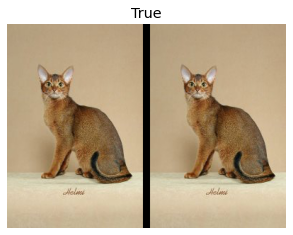

In [34]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show();

We can also try with a second image that's not from the same class:

같은 클래스에 속하지 않은 두 번째 이미지로 시도 할 수도 있습니다.

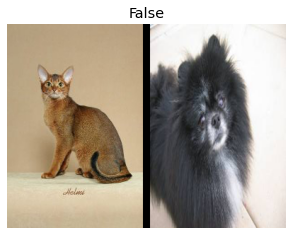

In [35]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

The important thing with transforms that we saw before is that they dispatch over tuples or their subclasses. That's precisely why we chose to subclass `fastuple` in this instance—this way we can apply any transform that works on images to our `SiameseImage` and it will be applied on each image in the tuple:

이전에 보았던 트랜스 폼의 중요한 점은 튜플이나 서브 클래스를 통해 디스패치한다는 것입니다. 
이것이 바로이 인스턴스에서`fastuple`을 서브 클래스로 선택한 이유입니다. 
이렇게하면 이미지에서 작동하는 모든 변환을`SiameseImage`에 적용 할 수 있으며 튜플의 각 이미지에 적용됩니다.

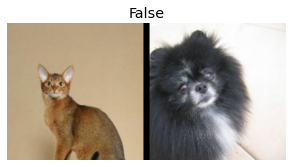

In [36]:
s2 = Resize(224)(s1)
s2.show();

Here the `Resize` transform is applied to each of the two images, but not the Boolean flag. Even if we have a custom type, we can thus benefit from all the data augmentation transforms inside the library.

여기서 'Resize'변환은 두 이미지 각각에 적용되지만 부울 플래그는 적용되지 않습니다. 사용자 정의 유형이 있더라도 라이브러리 내부의 모든 데이터 증가 변환의 이점을 누릴 수 있습니다.

We are now ready to build the `Transform` that we will use to get our data ready for a Siamese model. First, we will need a function to determine the classes of all our images:

이제 Siamese 모델을 위해 데이터를 준비하는 데 사용할`Transform`을 빌드 할 준비가되었습니다. 먼저 모든 이미지의 클래스를 결정하는 함수가 필요합니다.

In [37]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

For each image our tranform will, with a probability of 0.5, draw an image from the same class and return a `SiameseImage` with a true label, or draw an image from another class and return a `SiameseImage` with a false label. This is all done in the private `_draw` function. There is one difference between the training and validation sets, which is why the transform needs to be initialized with the splits: on the training set we will make that random pick each time we read an image, whereas on the validation set we make this random pick once and for all at initialization. This way, we get more varied samples during training, but always the same validation set:

각 이미지에 대해 변환은 0.5 확률로 동일한 클래스에서 이미지를 그리고 실제 레이블이있는 'SiameseImage'를 반환하거나 다른 클래스에서 이미지를 그리고 거짓 레이블이있는 'SiameseImage'를 반환합니다. 이것은 모두 private`_draw` 함수에서 수행됩니다. 훈련 세트와 검증 세트 사이에는 한 가지 차이점이 있습니다. 이것이 바로 변환이 분할로 초기화되어야하는 이유입니다. 훈련 세트에서는 이미지를 읽을 때마다 무작위로 선택하는 반면 검증 세트에서는 이것을 무작위로 만듭니다. 초기화시 한 번만 선택하십시오. 이렇게하면 훈련 중에 더 다양한 샘플을 얻을 수 있지만 항상 동일한 유효성 검사 세트를 얻을 수 있습니다.

In [38]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

We can then create our main transform:
그런 다음 주요 변환을 만들 수 있습니다.

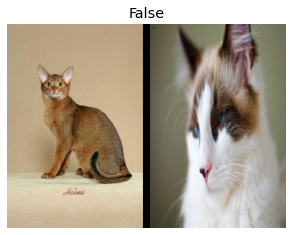

In [39]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();

In the mid-level API for data collection we have two objects that can help us apply transforms on a set of items, `TfmdLists` and `Datasets`. If you remember what we have just seen, one applies a `Pipeline` of transforms and the other applies several `Pipeline` of transforms in parallel, to build tuples. Here, our main transform already builds the tuples, so we use `TfmdLists`:
데이터 수집을위한 중간 수준의 API에는 항목 집합 'TfmdLists'및 'Datasets'에 변환을 적용하는 데 도움이되는 두 개의 개체가 있습니다. 방금 본 것을 기억한다면, 하나는 변환의`파이프 라인 '을 적용하고 다른 하나는 튜플을 만들기 위해 여러 개의 변환`파이프 라인'을 병렬로 적용합니다. 여기에서 주 변환은 이미 튜플을 빌드하므로`TfmdLists`를 사용합니다.

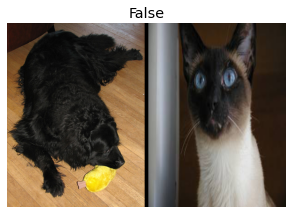

In [40]:
tls = TfmdLists(files, tfm, splits=splits)
show_at(tls.valid, 0);

And we can finally get our data in `DataLoaders` by calling the `dataloaders` method. One thing to be careful of here is that this method does not take `item_tfms` and `batch_tfms` like a `DataBlock`. The fastai `DataLoader` has several hooks that are named after events; here what we apply on the items after they are grabbed is called `after_item`, and what we apply on the batch once it's built is called `after_batch`:
그리고 마지막으로`dataloaders` 메소드를 호출하여`DataLoaders`에서 데이터를 가져올 수 있습니다. 여기서주의해야 할 점은이 메소드가`DataBlock`처럼 ʻitem_tfms`와`batch_tfms`를 취하지 않는다는 것입니다. fastai`DataLoader`에는 이벤트 이름을 따서 명명 된 몇 가지 후크가 있습니다. 여기에서 항목을 잡은 후 적용하는 항목을 ʻafter_item`이라고하고 빌드 한 후 배치에 적용하는 항목을 ʻafter_batch`라고합니다.

In [41]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Note that we need to pass more transforms than usual—that's because the data block API usually adds them automatically:

평소보다 더 많은 변환을 전달해야합니다. 이는 데이터 블록 API가 일반적으로 자동으로 추가하기 때문입니다.

- `ToTensor` is the one that converts images to tensors (again, it's applied on every part of the tuple).

`ToTensor`는 이미지를 텐서로 변환하는 것입니다 (다시 말하지만 튜플의 모든 부분에 적용됨).

- `IntToFloatTensor` converts the tensor of images containing integers from 0 to 255 to a tensor of floats, and divides by 255 to make the values between 0 and 1.

ʻIntToFloatTensor`는 0에서 255 사이의 정수를 포함하는 이미지의 텐서를 float의 텐서로 변환하고 255로 나누어 0과 1 사이의 값을 만듭니다.

We can now train a model using this `DataLoaders`. It will need a bit more customization than the usual model provided by `cnn_learner` since it has to take two images instead of one, but we will see how to create such a model and train it in <<chapter_arch_dtails>>.

이제이`DataLoaders`를 사용하여 모델을 훈련 할 수 있습니다. 하나가 아닌 두 개의 이미지를 가져와야하기 때문에`cnn_learner`에서 제공하는 일반적인 모델보다 약간 더 많은 사용자 정의가 필요하지만 이러한 모델을 만들고 << chapter_arch_dtails >>에서 훈련하는 방법을 살펴 보겠습니다.

In [42]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [43]:
encoder = create_body(resnet34, cut=-2)
head = create_head(512*4, 2, ps=0.5)
model = SiameseModel(encoder, head)
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out, targ.long())
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [44]:
learn = Learner(dls, model, loss_func=loss_func, 
                splitter=siamese_splitter, metrics=accuracy)
learn.freeze()
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.538704,0.369431,0.831529,00:37
1,0.370305,0.225888,0.903924,00:36
2,0.288504,0.168362,0.941813,00:37
3,0.245282,0.168213,0.937077,00:37


In [45]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.227896,0.157704,0.937077,00:49
1,0.226722,0.151081,0.942490,00:49
2,0.220954,0.146950,0.945873,00:50
3,0.230000,0.151542,0.941137,00:50


## Conclusion

fastai provides a layered API. It takes one line of code to grab the data when it's in one of the usual settings, making it easy for beginners to focus on training a model without spending too much time assembling the data. Then, the high-level data block API gives you more flexibility by allowing you to mix and match some building blocks. Underneath it, the mid-level API gives you greater flexibility to apply any transformations on your items. In your real-world problems, this is probably what you will need to use, and we hope it makes the step of data-munging as easy as possible.

fastai는 계층화 된 API를 제공합니다. 일반적인 설정 중 하나에있을 때 데이터를 가져 오는 데 한 줄의 코드가 필요하므로 초보자가 데이터를 조립하는 데 너무 많은 시간을 들이지 않고도 쉽게 모델 학습에 집중할 수 있습니다. 그런 다음 고급 데이터 블록 API를 사용하면 일부 빌딩 블록을 혼합하고 일치시킬 수 있으므로 더 많은 유연성을 얻을 수 있습니다. 그 아래에서 중간 수준 API는 항목에 변형을 적용 할 수있는 더 큰 유연성을 제공합니다. 실제 문제에서 이것은 아마도 당신이 사용해야 할 것이고, 우리는 이것이 가능한 한 쉽게 데이터 통합 단계를 만들길 바랍니다.

## Questionnaire

1. Why do we say that fastai has a "layered" API? What does it mean?

fastai에 "계층화 된"API가 있다고 말하는 이유는 무엇입니까? 무슨 뜻이에요?

1. Why does a `Transform` have a `decode` method? What does it do?

왜`Transform`에`decode` 메소드가 있습니까? 그것은 무엇을합니까?

1. Why does a `Transform` have a `setup` method? What does it do?

`Transform`에`setup` 메소드가있는 이유는 무엇입니까? 그것은 무엇을합니까?

1. How does a `Transform` work when called on a tuple?

튜플에서 호출 될 때`Transform`은 어떻게 작동합니까?

1. Which methods do you need to implement when writing your own `Transform`?

자신 만의`Transform`을 작성할 때 어떤 메소드를 구현해야합니까?

1. Write a `Normalize` transform that fully normalizes items (subtract the mean and divide by the standard deviation of the dataset), and 
that can decode that behavior. Try not to peek!

항목을 완전히 정규화하고 (평균을 빼고 데이터 세트의 표준 편차로 나누기) 해당 동작을 디코딩 할 수있는`Normalize` 변환을 작성합니다. 엿 보지 마십시오!

1. Write a `Transform` that does the numericalization of tokenized texts (it should set its vocab automatically from the dataset seen and have a `decode` method). Look at the source code of fastai if you need help.

토큰 화 된 텍스트의 수치화를 수행하는`Transform`을 작성합니다 (표시된 데이터 세트에서 자동으로 어휘를 설정하고`decode` 메소드를 가져야합니다). 도움이 필요하면 fastai의 소스 코드를보십시오.

1. What is a `Pipeline`?

`파이프 라인`이란?

1. What is a `TfmdLists`? 

`TfmdLists`는 무엇입니까?

1. What is a `Datasets`? How is it different from a `TfmdLists`?

`데이터 세트`란 무엇입니까? `TfmdLists`와 어떻게 다른가요?

1. Why are `TfmdLists` and `Datasets` named with an "s"?

왜`TfmdLists`와`Datasets`는 "s"로 명명됩니까?

1. How can you build a `DataLoaders` from a `TfmdLists` or a `Datasets`?

`TfmdLists` 또는`Datasets`에서`DataLoaders`를 어떻게 빌드 할 수 있습니까?

1. How do you pass `item_tfms` and `batch_tfms` when building a `DataLoaders` from a `TfmdLists` or a `Datasets`?

`TfmdLists` 또는`Datasets`에서`DataLoaders`를 빌드 할 때 ʻitem_tfms` 및`batch_tfms`를 어떻게 전달합니까?

1. What do you need to do when you want to have your custom items work with methods like `show_batch` or `show_results`?

사용자 지정 항목이`show_batch` 또는`show_results`와 같은 메서드와 함께 작동하도록하려면 무엇을해야합니까?

1. Why can we easily apply fastai data augmentation transforms to the `SiamesePair` we built?

구축 한`SiamesePair`에 fastai 데이터 증가 변환을 쉽게 적용 할 수있는 이유는 무엇입니까?

### Further Research

1. Use the mid-level API to prepare the data in `DataLoaders` on your own datasets. Try this with the Pet dataset and the Adult dataset from Chapter 1.

중간 수준 API를 사용하여 자체 데이터 세트의 'DataLoaders'에 데이터를 준비합니다. 1 장의 Pet 데이터 셋과 Adult 데이터 셋을 사용해보십시오.

1. Look at the Siamese tutorial in the fastai documentation to learn how to customize the behavior of `show_batch` and `show_results` for new type of items. Implement it in your own project.

새로운 유형의 항목에 대해`show_batch` 및`show_results`의 동작을 사용자 정의하는 방법을 배우려면 fastai 문서의 Siamese 튜토리얼을 참조하십시오. 자신의 프로젝트에서 구현하십시오.

## Understanding fastai's Applications: Wrap Up(fastai의 응용 프로그램 이해 : 마무리)

Congratulations—you've completed all of the chapters in this book that cover the key practical parts of training models and using deep learning! You know how to use all of fastai's built-in applications, and how to customize them using the data block API and loss functions. You even know how to create a neural network from scratch, and train it! (And hopefully you now know some of the questions to ask to make sure your creations help improve society too.)

축하합니다. 학습 모델과 딥 러닝 사용의 핵심적인 실제 부분을 다루는이 책의 모든 장을 완료했습니다! fastai의 모든 내장 애플리케이션을 사용하는 방법과 데이터 블록 API 및 손실 함수를 사용하여이를 사용자 정의하는 방법을 알고 있습니다. 신경망을 처음부터 만들고 훈련시키는 방법도 알고 있습니다! (그리고 이제 여러분의 창작물이 사회를 개선하는 데 도움이되는지 확인하기 위해 물어볼 몇 가지 질문을 알고 계셨기를 바랍니다.)

The knowledge you already have is enough to create full working prototypes of many types of neural network applications. More importantly, it will help you understand the capabilities and limitations of deep learning models, and how to design a system that's well adapted to them.

이미 가지고있는 지식은 다양한 유형의 신경망 애플리케이션의 완전한 작동 프로토 타입을 만드는 데 충분합니다. 더 중요한 것은 딥 러닝 모델의 기능과 한계를 이해하고 모델에 잘 적응하는 시스템을 설계하는 방법을 이해하는 데 도움이됩니다.

In the rest of this book we will be pulling apart those applications, piece by piece, to understand the foundations they are built on. This is important knowledge for a deep learning practitioner, because it is what allows you to inspect and debug models that you build and create new applications that are customized for your particular projects.

이 책의 나머지 부분에서는 이러한 응용 프로그램이 구축 된 기반을 이해하기 위해 이러한 응용 프로그램을 하나씩 분리 할 것입니다. 이는 딥 러닝 실무자에게 중요한 지식입니다. 특정 프로젝트에 맞게 사용자 정의 된 새 애플리케이션을 빌드하고 생성하는 모델을 검사하고 디버그 할 수 있기 때문입니다.